After tested all methods which are listed in doc file, random forest classification gave the highest f1_weighted score.

In [0]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.figure_factory as ff
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

plotly.tools.set_credentials_file(username='DacNguyen', api_key='lojmB52uk2BsQsAfqMpx')
warnings.filterwarnings('ignore')

In [0]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';', header=0)

df_X = df.iloc[:, 0:(len(df.columns) - 1)]
df_y = df.loc[:, 'quality']

df_y.replace(range(0, 5), 0, inplace = True)
df_y.replace(range(5, 7), 1, inplace = True)
df_y.replace(range(7, 11), 2, inplace = True)

train_X, test_X, train_y, test_y = train_test_split(df_X, df_y, test_size=0.3, random_state=2019)


In [0]:
clfs = [LinearRegression(), LogisticRegression(), GaussianNB(),
        RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0),
        RandomForestRegressor(n_estimators=30, max_depth=10, random_state=0)]
kfold_score_func = lambda clf: np.mean(cross_val_score(clf, X=train_X, y=train_y, cv=10))

name, acc = zip(*[(clf.__class__, kfold_score_func(clf)) for clf in clfs])
name = [str(n).split('.')[-1] for n in name]

pd.DataFrame(data={'name': name, 'accuracy': acc}, columns=['name', 'accuracy'])\
    .sort_values('accuracy', ascending=False)

,name,accuracy
3,RandomForestClassifier'>,0.849921
1,LogisticRegression'>,0.821371
2,GaussianNB'>,0.784648
4,RandomForestRegressor'>,0.319003
0,LinearRegression'>,0.218342


### Functions 

In [0]:
def pre_processing(df):
  df_X = df.iloc[:, 0:(len(df.columns) - 1)]
  df_y = df.loc[:, 'quality']

  df_y.replace(range(0, 5), 0, inplace = True)
  df_y.replace(range(5, 7), 1, inplace = True)
  df_y.replace(range(7, 11), 2, inplace = True)
  
  # Generate train and test sets
  train_X, test_X, train_y, test_y = train_test_split(df_X, df_y, test_size=0.3, random_state=2019)

  scaler = StandardScaler().fit(train_X)
  train_scale_X = scaler.transform(train_X)
  test_scale_X = scaler.transform(test_X)
    
  return train_scale_X, test_scale_X, train_X, test_X, train_y, test_y

def run_random_forest_classification(path):
  # Load dataset
  df = pd.read_csv(path, sep=';', header=0)
  
  # Pre-processing
  train_scale_X, test_scale_X, train_X, test_X, train_y, test_y = pre_processing(df)
  # PCA and Reduction
  pca = PCA(n_components=0.95, svd_solver="full").fit(train_scale_X)
  train_X, test_X = pca.transform(train_X), pca.transform(test_X)

  # Random forest training
  clf_rfc = RandomForestClassifier()
  parameters = {'n_estimators': range(50, 120, 10), 'max_depth': range(10, 50, 5)}
  clf = GridSearchCV(clf_rfc, parameters, cv=5, verbose=1, n_jobs=-1, scoring='f1_weighted')
  clf.fit(train_X, train_y)

  print('Best parameters: {params} with accurate: {score}'.format(params=clf.best_params_,
                                                                  score=clf.best_score_))
  # Predict data
  predicted_y = clf.predict(test_X)

  acc = accuracy_score(test_y, predicted_y)
  prec, rec, f_score, support = precision_recall_fscore_support(test_y, predicted_y, average='weighted')

  print('Final Scores\n\taccuracy: {acc}, precision: {prec}, recall: {rec}, f score: {f_score}'
        .format(acc=acc.round(3), prec=prec.round(3), rec=rec.round(3), f_score=f_score.round(3)))

  labels = pd.Series(test_y.append(pd.Series(predicted_y))).unique()
  labels.sort()

  cfs_matrix = confusion_matrix(test_y, predicted_y, labels=labels)
  return cfs_matrix, labels, pca, np.corrcoef(train_scale_X.T)

def plot_heat_map(title, labels, cfs_matrix):
  data = [
      go.Heatmap(
          z=cfs_matrix,
          x=labels,
          y=labels,
          colorscale='Viridis',
      )
  ]

  layout = go.Layout(
      title=title,
      xaxis=dict(title='Predicted Quality'),
      yaxis=dict(title='True Quality')
  )

  fig = go.Figure(data=data, layout=layout)
  return fig


### Red Wine

In [0]:
cfs_matrix_rw, labels_rw, pca_matrix_rw, corr_rw = run_random_forest_classification("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   46.9s finished


Best parameters: {'max_depth': 20, 'n_estimators': 80} with accurate: 0.8076010952861324
Final Scores
	accuracy: 0.873, precision: 0.837, recall: 0.873, f score: 0.851


*PCA*

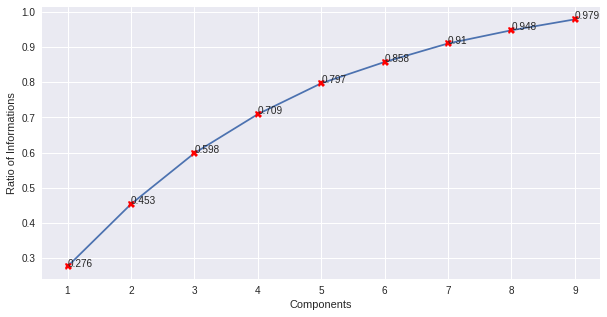

In [0]:
%matplotlib inline  

plt.figure(figsize=(10,5))
plt.plot(range(1, 10), np.cumsum(pca_matrix_rw.explained_variance_ratio_), marker='X', markerfacecolor='r')
plt.xticks(range(1, 10))
plt.xlabel('Components')
plt.ylabel('Ratio of Informations')

axis_rw = [plt.annotate(b, (a, b)) for a, b in
           zip(range(1, 10), np.round(np.cumsum(pca_matrix_rw.explained_variance_ratio_), 3))]
plt.show()

*Heatmap of Correlation Matrix*

In [0]:
data = [
    go.Heatmap(
        z=corr_rw,
        colorscale='Viridis'
    )
]

layout = go.Layout(
    title='Correlation Matrix of Red Wine'
)

fig_corr_rw = go.Figure(data=data, layout=layout)
py.iplot(fig_corr_rw, filename='red-wine')

*Heatmap of Confusion Matrix*

In [0]:
fig_rw = plot_heat_map('Confusion Matrix of Red Wine', ['low', 'average', 'high'], cfs_matrix_rw)
py.iplot(fig_rw, filename='red-wine')

### White wine

In [0]:
cfs_matrix_ww, labels_ww, pca_matrix_ww, corr_ww = run_random_forest_classification("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv")

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  2.2min finished


Best parameters: {'max_depth': 20, 'n_estimators': 80} with accurate: 0.7738164255536951
Final Scores
	accuracy: 0.81, precision: 0.798, recall: 0.81, f score: 0.787


*PCA*

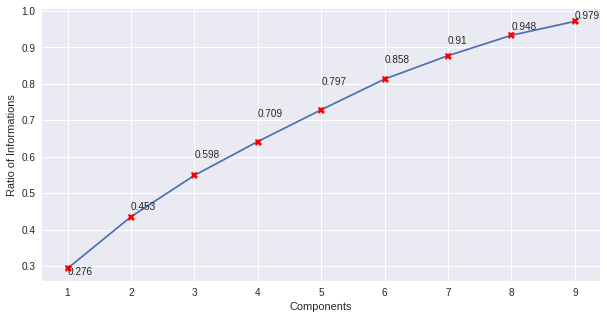

In [0]:
%matplotlib inline  

plt.figure(figsize=(10,5))
plt.plot(range(1, 10), np.cumsum(pca_matrix_ww.explained_variance_ratio_), marker='X', markerfacecolor='r')
plt.xticks(range(1, 10))
plt.xlabel('Components')
plt.ylabel('Ratio of Informations')

axis_ww = [plt.annotate(b, (a, b)) for a, b in
           zip(range(1, 10), np.round(np.cumsum(pca_matrix_rw.explained_variance_ratio_), 3))]
plt.show()

*Heatmap of Correlation Matrix*

In [0]:
data = [
    go.Heatmap(
        z=corr_ww,
        colorscale='Viridis'
    )
]

layout = go.Layout(
    title='Correlation Matrix of Red Wine'
)

fig_corr_ww = go.Figure(data=data, layout=layout)
py.iplot(fig_corr_ww, filename='white-wine')

*Heatmap of Confusion Matrix*

In [0]:
fig_ww = plot_heat_map('Confusion Matrix of White Wine', ['low', 'average', 'high'], cfs_matrix_ww)
py.iplot(fig_ww, filename='white-wine')